# __Problem__

Develop a tool to calculate the optimal number of bikes/scooters needed at each station at any given time and also to plan efficient routes for maintenance teams to repair and redistribute them accordingly.

## Problem Setting (temporary):
- stations: bikes/scooters station (where they must be placed)
- pick_up: scooters can start and end anywhere in the city, so we need to collect them
- nodes: pick_up and stations positions (places that the cargo van may visit)
- demand: forecast the 'optimal' number of bikes/scooters needed at each station for different times of the day
- load: number of bikes/scooters available at each node (cargo van)
- capacity: maximum number of bikes/scooters a cargo van can transport at the same time (generated by us)
- TW: time window for each station (demand should be ensured at any given time of day)
- distance matrix: matrix with the distance between all nodes

## Predictive Analytics:
- forecast future demand for each station
- analyze consumer and trips patterns (identify/understand the target customer)

## Derive from data: ##
- station locations coordinates (that are fixed)
- best locations to place the scooters (_not considered by now_)
- expected demand for different periods of the day (_consider 4 time periods_)
- distance matrix
- travel time between stations
- CO2 "saved" emissions for bikes and scooters

# Dummy Study

Consider the package [VRPy](https://vrpy.readthedocs.io/en/latest/index.html "VRPy").

### CVRP with Pickup and Deliveries (VRPPD)

Working on:
- DiGraph design: https://networkx.org/documentation/stable/reference/classes/digraph.html

  example: https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python

In [1]:
# install packages
import sys
#!{sys.executable} -m pip install mpu python-tsp
#!{sys.executable} -m pip install mpu
#!{sys.executable} -m pip install networkx
#!{sys.executable} -m pip install vrpy

# Simulation
Operational Solution (move resources to where they are needed)

:param N: nodes number (clusters)

:param distance_matrix: list of  [[0,...], ...]

:param forecast: dict {station: expected number of vehicles, ... }

:param system_state: dict {station: real number of vehicles, ... }

:return: cost

In [9]:
import math
import mpu
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from vrpy import VehicleRoutingProblem
from networkx import DiGraph, from_numpy_matrix, relabel_nodes, set_node_attributes
from numpy import array

N = 20  # clusters

# DATA
# read nodes positions
pos = pd.read_csv('df_c20.csv').to_dict()
coordinates = {_+1: (pos['0'][_], pos['1'][_]) for _ in range(N)}

# Distance matrix
distance = [[round(mpu.haversine_distance(coordinates[i], coordinates[j]), 1) for j in range(1, N+1)] for i in range(1, N+1)]

# Expected Demands (key: station, value: amount)
fluxo = pd.read_parquet('group_out_clusters.parquet', engine='pyarrow')  # demand.
Demand = fluxo.to_dict()[('all_AB', 'mean')]
Demand = {_+1: int(round(Demand[_], 0)) for _ in Demand}
print("Travellers per cluster:", Demand)

# System Oportunity observation (inactive scooters from 0h - 20h)
pos = pd.read_csv('coiso.csv').to_dict()
State = {pos['cluster'][_]+1: pos['0'][_] for _ in pos['cluster']}
State.update({_ : 0 for _ in [k for k in range(1, N+1) if k not in State.keys()]})
print("Scoters not used until 8pm per cluster:", State)
#print(sum([Demand[_] for _ in Demand]), sum([State[_] for _ in State]), State)
#print("availability_defice", sum([availability_defice[_] for _ in availability_defice]), availability_defice)

Travellers per cluster: {1: 7, 2: 7, 3: 9, 4: 7, 5: 7, 6: 11, 7: 8, 8: 9, 9: 8, 10: 8, 11: 7, 12: 9, 13: 8, 14: 8, 15: 8, 16: 8, 17: 8, 18: 7, 19: 7, 20: 8}
Scoters not used until 8pm per cluster: {1: 2, 2: 1, 4: 0, 7: 1, 9: 21, 10: 1, 11: 1, 12: 0, 13: 0, 15: 0, 17: 2, 18: 1, 19: 0, 20: 0, 3: 0, 5: 0, 6: 0, 8: 0, 14: 0, 16: 0}


In [11]:
from operator import itemgetter

# Check where we need the scooters
scooters_availability = {_: State[_]-Demand[_] for _ in range(1, N+1)}
print("Scooters availability:", scooters_availability)

# Filter the locations as pickup or dropout
pickup_nodes = [_ for _ in scooters_availability if scooters_availability[_] > 0]  # has excess of scooters inactive until 20h
dropout_nodes = [_ for _ in scooters_availability if scooters_availability[_] < 0]  # has a need of scooters
move_scooters = sum([scooters_availability[_] for _ in pickup_nodes])  # check the number of scooters we will move

# Define to where we will move the scooters (dummy)
pickups_deliveries = {}
destination = list(dict(sorted({_: abs(scooters_availability[_]) for _ in dropout_nodes}.items(), key = itemgetter(1), reverse = True)[:move_scooters]).keys())
for pick in pickup_nodes:
    pickups_deliveries = {(pick, drop): 1 for drop in destination}


Scooters availability: {1: -5, 2: -6, 3: -9, 4: -7, 5: -7, 6: -11, 7: -7, 8: -9, 9: 13, 10: -7, 11: -6, 12: -9, 13: -8, 14: -8, 15: -8, 16: -8, 17: -6, 18: -6, 19: -7, 20: -8}


Clusters to collect scooters: {9: 13}
Clusters to place scooters: {3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 10: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 20: 1}
Route [9, 3, 15, 20, 5, 10, 12, 7, 13, 4, 16, 8, 6, 14]
Edges [(9, 3), (3, 15), (15, 20), (20, 5), (5, 10), (10, 12), (12, 7), (7, 13), (13, 4), (4, 16), (16, 8), (8, 6), (6, 14)]


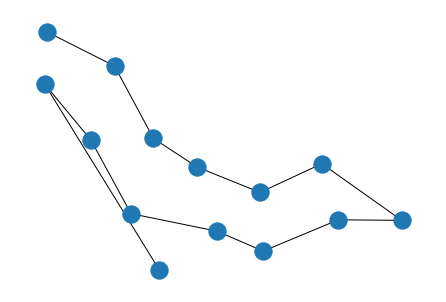

In [29]:
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search


collect = {node: sum([pickups_deliveries[pair] for pair in pickups_deliveries if pair[0] == node]) for node in set([_[0] for _ in pickups_deliveries])}
print("Clusters to collect scooters:", collect)
deliver = {node: sum([pickups_deliveries[pair] for pair in pickups_deliveries if pair[1] == node]) for node in set([_[1] for _ in pickups_deliveries])}
print("Clusters to place scooters:", deliver)

nodes, newID = list(collect.keys())+list(deliver.keys()), {_: sorted(deliver)[_] for _ in range(len(deliver))}  # aux variables

distancePROBBLEM = np.array([[round(mpu.haversine_distance(coordinates[i], coordinates[j]), 1) for j in list(deliver.keys())] for i in list(deliver.keys())])  # distance array

permutation, distance = solve_tsp_dynamic_programming(distancePROBBLEM)  # solve tsp
route = list(collect.keys())+[newID[_] for _ in permutation]
edges = [(route[_], route[_+1]) for _ in range(len(route)-1)]
print("Route", route)
print("Edges", edges)

# PLOT
G = nx.Graph()
G_pos = {_:  coordinates[_] for _ in nodes}
G.add_nodes_from(G_pos.keys())
G.add_edges_from(edges)
nx.draw(G, G_pos)
plt.show()

In [33]:
#CO2 emissions

# Demand

scenarios = [.1, .25, .5, 1]
for per in scenarios:
    scen_demand = int(sum([Demand[_] for _ in Demand])*per)
    co = 0.0918
    random_dist = []
    for _ in range(100):
        random_dist.append(random.randint(10, 35)/10*co*scen_demand)                  
    print("CO2 (g)"sum(random_dist)/len(random_dist))
                       
        



3.1120200000000007
8.2559412
16.875869399999996
32.25760200000001


# Semanalmente é feito uma alocação das trotinetes a cada um dos postos.
# Durante o dia faz-se o pickup and delivery (em diferentes momentos do dia)

In [7]:
import pandas as pd
teste = pd.read_parquet('VAMO_LA_BICICLETA.parquet', engine='pyarrow')
teste

,vehicle_id,start_time,end_time,distance,saved_emissions,duration,month,weekday,start_hour,year,lon_i,lat_i,lon_f,lat_f,weekofyear
0,1,2020-02-05 18:29:07.131,2020-02-05 19:08:01.426,3.141590000,0.278410000,2334.295,2,Wednesday,18,2020,-8.680990,41.152393,-8.609615,41.173203,6
1,1,2019-04-10 13:08:14.233,2019-04-10 13:15:57.168,1571.000000000,138.248000000,462.935,4,Wednesday,13,2019,-8.681177,41.172016,-8.677280,41.178501,15
2,1,2019-04-10 11:54:01.106,2019-04-10 12:06:31.362,1862.000000000,163.856000000,750.256,4,Wednesday,11,2019,-8.681298,41.172352,-8.678202,41.179234,15
3,1,2019-04-10 17:26:22.795,2019-04-10 17:34:33.641,661.000000000,58.168000000,490.846,4,Wednesday,17,2019,-8.680945,41.172188,-8.679880,41.174046,15
4,1,2019-04-10 17:54:34.813,2019-04-10 18:10:45.657,2316.000000000,203.808000000,970.844,4,Wednesday,17,2019,-8.691840,41.171223,-8.680222,41.177299,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,4483,2021-10-18 11:11:59.999,2021-10-18 12:50:38.762,104.700000000,13.828770000,5918.763,10,Monday,11,2021,-8.683282,41.182457,-8.682838,41.182526,42
1615,4485,2021-08-19 13:59:11.769,2021-08-19 14:00:22.329,131.500000000,17.368510000,70.560,8,Thursday,13,2021,-8.680152,41.172329,-8.678948,41.172943,33
1616,4485,2021-08-19 14:26:35.444,2021-08-19 14:29:29.093,706.300000000,93.288090000,173.649,8,Thursday,14,2021,-8.679892,41.171951,-8.678430,41.172798,33
1617,4485,2021-08-19 14:18:33.238,2021-08-19 14:19:08.843,25.200000000,3.328420000,35.605,8,Thursday,14,2021,-8.678601,41.172218,-8.678601,41.172218,33
